In [1]:
from SimPEG import *
from simpegem1d import EM1D, EM1DAnal, Kernels, RTEfun, DigFilter, BaseEM1D, Utils1D
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
TDsurvey = BaseEM1D.EM1DSurveyTD()
TDsurvey.rxLoc = np.array([0., 0., 100.+30.])
TDsurvey.srcLoc = np.array([0., 0., 100.+30.])
TDsurvey.fieldtype = 'secondary'
TDsurvey.rxType = 'dBzdt'
TDsurvey.waveType = 'stepoff'
TDsurvey.srcType = 'CircularLoop'
# TDsurvey.offset = 1e-5
TDsurvey.a = 2.5
TDsurvey.I = 1.
cs = 10.
nearthick = np.logspace(-1, 1, 3)
linthick = np.ones(15)*cs
deepthick = np.logspace(1, 2, 3)
hx = np.r_[nearthick, linthick, deepthick, deepthick[-1]]
mesh1D = Mesh.TensorMesh([hx], [0.])
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC
nlay = depth.size
TDsurvey.depth = depth
TDsurvey.topo = np.r_[0., 0., 100.]
TDsurvey.LocSigZ = LocSigZ
TDsurvey.time = np.logspace(-4, -3, 16)
TDsurvey.switchInterp = False
TDsurvey.setFrequency(TDsurvey.time)
TDsurvey.Setup1Dsystem()
sig_half = 1e-4
sig_blk = 1e-2
chi_half = 0.
expmap = BaseEM1D.BaseEM1DMap(mesh1D)

AttributeError: module 'simpegem1d.BaseEM1D' has no attribute 'BaseEM1DMap'

In [3]:
sig  = np.ones(nlay)*sig_half
blk_ind = (0>LocSigZ) & (-30<LocSigZ)
sig[blk_ind] = sig_blk
m_true = np.log(sig)

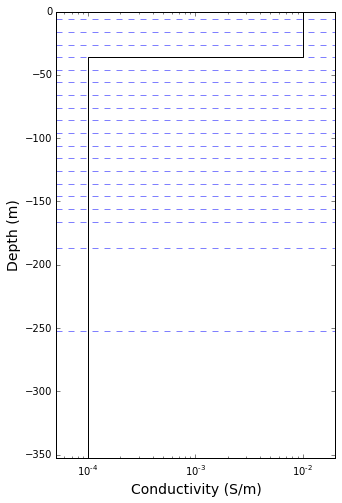

In [6]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ, showlayers=True)

In [7]:
%%time
WT0, WT1, YBASE = DigFilter.LoadWeights()
options = {'WT0': WT0, 'WT1': WT1, 'YBASE': YBASE}
prob = EM1D.EM1D(mesh1D, mapping=expmap, **options)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.CondType = 'Real'
prob.chi = np.zeros(TDsurvey.nlay)
d_true = TDsurvey.dpred(m_true)

CPU times: user 3.61 s, sys: 41.4 ms, total: 3.65 s
Wall time: 4.37 s


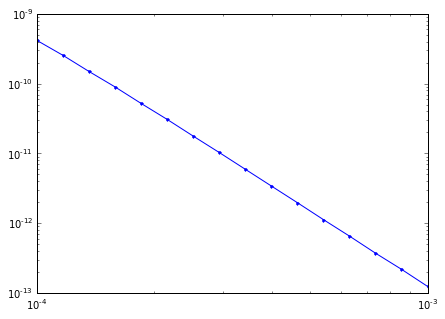

In [8]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -d_true, '.-')
axes.set_xscale('log');
axes.set_yscale('log');

In [9]:
TDsurvey.dtrue = d_true
std = 0.1
noise = std*abs(TDsurvey.dtrue)*np.random.randn(*TDsurvey.dtrue.shape)
floor = 1e-15
TDsurvey.dobs = TDsurvey.dtrue+noise
uncert = abs(TDsurvey.dobs)*std+floor
prob.jacSwitch = True

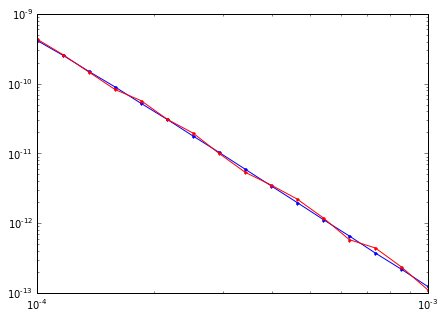

In [10]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -d_true, 'b.-')
axes.plot(TDsurvey.time, -TDsurvey.dobs, 'r.-')
axes.set_xscale('log');
axes.set_yscale('log');

In [11]:
dmisfit = DataMisfit.l2_DataMisfit(TDsurvey)
dmisfit.Wd = 1./(abs(TDsurvey.dobs)*std+floor)

In [12]:
m0 = np.log(np.ones_like(sig)*1e-3)
reg = Regularization.Tikhonov(mesh1D, mapping = expmap)
reg.mref = np.log(np.ones_like(sig)*1e-4)
opt = Optimization.InexactGaussNewton(maxIter = 5)
opt.maxIterLS = 5
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=10**0)
inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest])
reg.alpha_s = 1e-5
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 1.
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

In [13]:
mopt = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  2.27e+01  3.48e+02  2.03e-09  3.48e+02    4.15e+02      0              
   1  2.27e+01  2.60e+02  3.79e-09  2.60e+02    3.36e+02      2              
   2  4.54e+00  1.82e+02  1.18e-08  1.82e+02    3.05e+02      1   Skip BFGS  
   3  4.54e+00  1.11e+02  2.38e-08  1.11e+02    2.52e+02      1   Skip BFGS  
   4  9.09e-01  7.15e+01  6.77e-08  7.15e+01    3.11e+02      0   Skip BFGS  
   5  9.09e-01  2.34e+01  5.61e-08  2.34e+01    1.88e+01      0              
------------------------- STOP! -------------------------
0 : |fc-fOld| = 4.8141e+01 <= tolF*(1+|f0|) = 3.4928e+01
1 : |xc-x_last| = 3.8551e-01 <= tolX*(1+|x0|) = 

In [14]:
opt.counter.summary()
xc = opt.recall('xc')

Counters:
  InexactGaussNewton.doEndIteration       :        5
  InexactGaussNewton.doStartIteration     :        6
  InexactGaussNewton.scaleSearchDirection :        5

Times:                                        mean      sum
  EM1D.Jtvec_approx                       : 1.08e-01, 1.08e+00,   10x
  EM1D.Jvec_approx                        : 1.19e-01, 1.19e+00,   10x
  InexactGaussNewton.findSearchDirection  : 4.12e-01, 2.06e+00,    5x
  InexactGaussNewton.minimize             : 5.67e+02, 5.67e+02,    1x
  InexactGaussNewton.modifySearchDirection: 1.13e+02, 5.64e+02,    5x
  InexactGaussNewton.projection           : 9.17e-05, 2.75e-03,   30x


In [15]:
%%time
dpredall = []
maxIter = len(xc)
prob.jacSwitch = False
for i in range(maxIter):
    dpredtemp = TDsurvey.dpred(xc[i])
    dpredall.append(dpredtemp)

CPU times: user 18.3 s, sys: 386 ms, total: 18.7 s
Wall time: 22.5 s



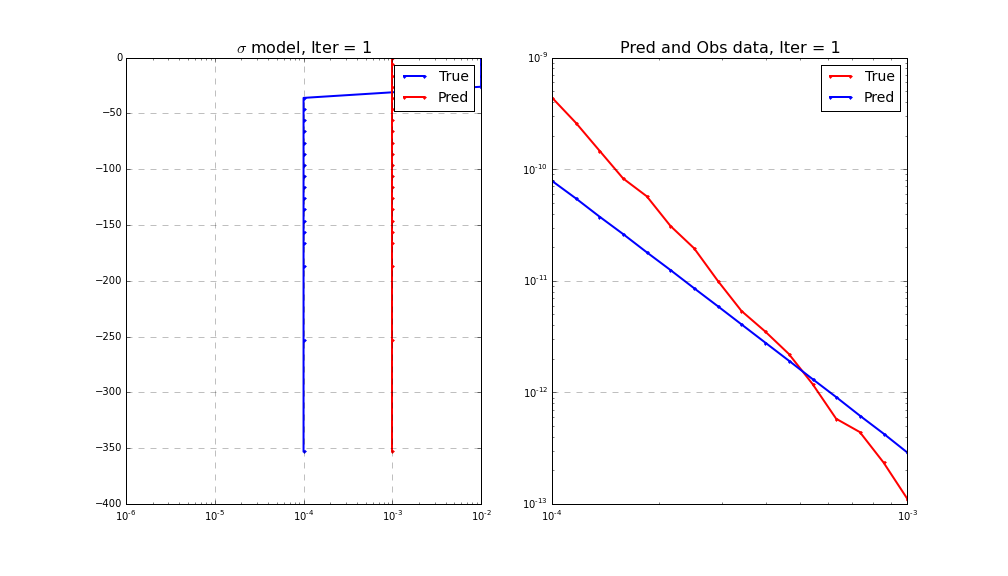
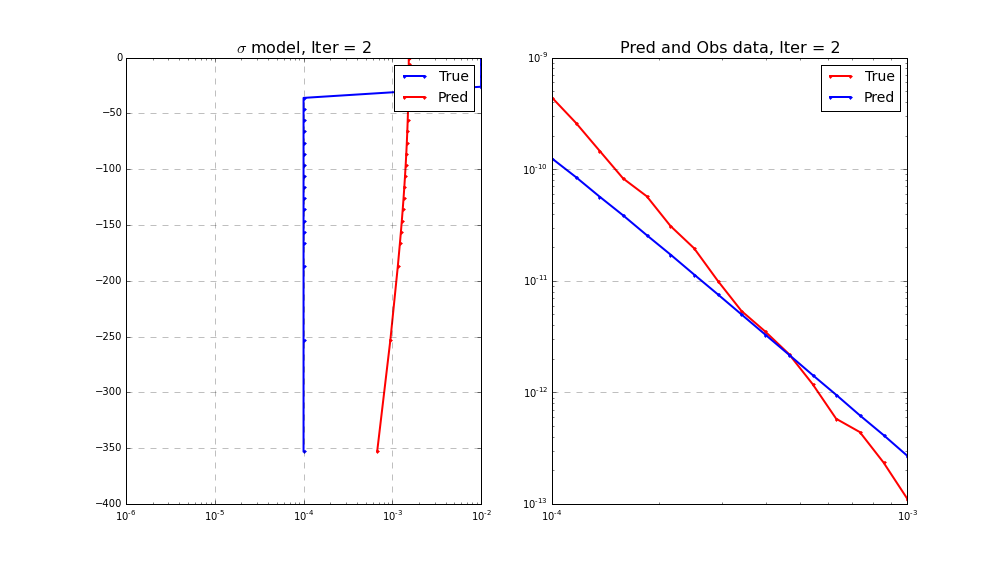
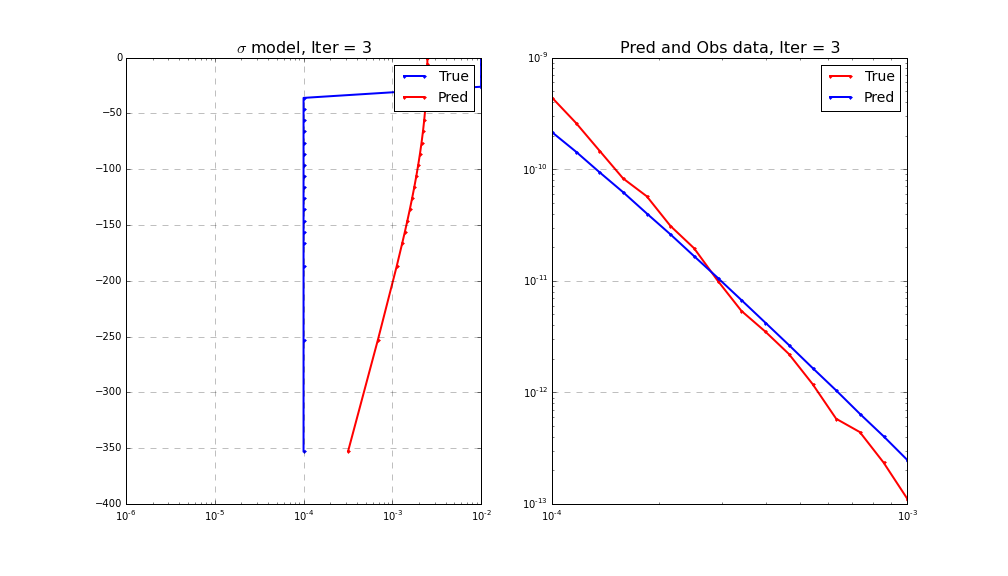
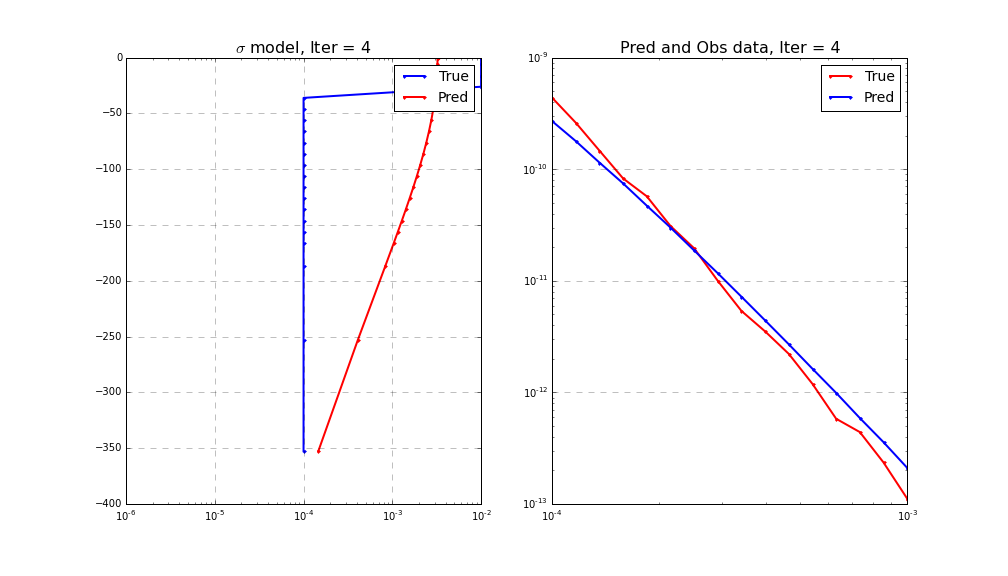
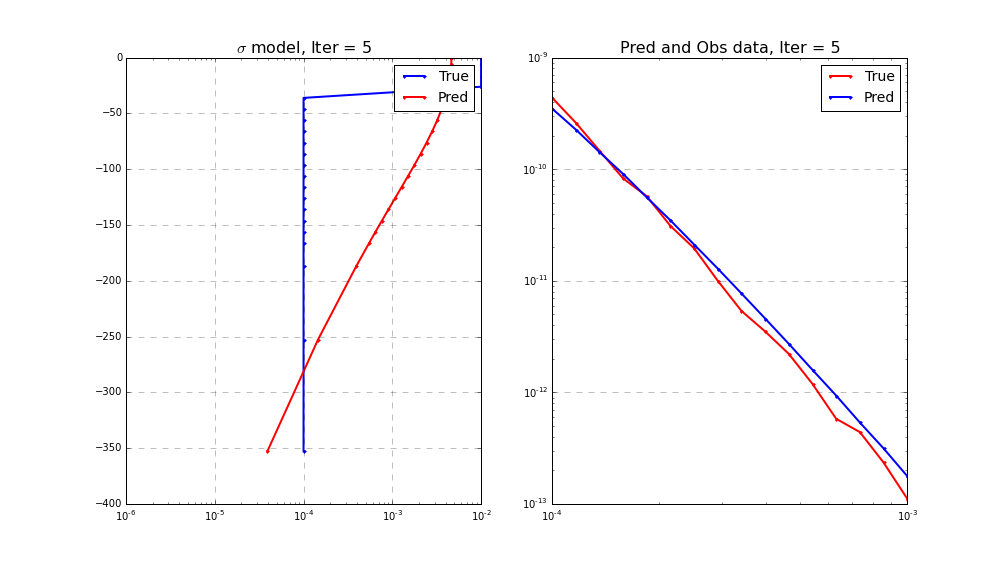

In [16]:
from JSAnimation import IPython_display
from matplotlib import animation

fig, ax = subplots(1,2, figsize=(14, 8))
ax[0].plot(sig, LocSigZ,  'b.-', lw=2)
ax[0].grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)
ax[1].grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)

ax[1].plot(TDsurvey.time, -(TDsurvey.dobs), 'r.-', lw=2)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[0].set_xlim(1e-6, 1e-2)


frame1, = ax[0].plot([], [],  'r.-', lw=2)
frame2, = ax[1].plot([], [],  'b.-' , lw=2)

def animate(i_id):
    
    frame1.set_data(expmap*xc[i_id], LocSigZ)
    frame2.set_data(TDsurvey.time, -(dpredall[i_id]))
    
    ax[0].legend(('True', 'Pred'), loc=1, fontsize = 14)
    ax[1].legend(('True', 'Pred'), loc=1, fontsize = 14)
    
    ax[0].set_title('$\sigma$ model, Iter = ' + str(i_id+1), fontsize = 16)
    ax[1].set_title('Pred and Obs data, Iter = ' + str(i_id+1), fontsize = 16)
    return frame1, frame2

animation.FuncAnimation(fig, animate, frames=maxIter, interval=40, blit=True)

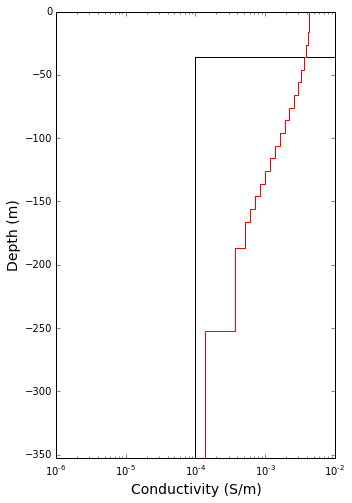

In [17]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ)
Utils1D.plotLayer(expmap*mopt, LocSigZ, showlayers=False,xlim=(1e-6, 1e-2), **{'color':'r'})

In [18]:
EM1DAnal.SkinDepth(7200., 1e-4)

593.13545284764757